# Dask

When you have more demanding (as in huge data size or costly algorithm) or complex (as in multiple, often non-linear sequence of steps), you will probably want to:

- make use of all the cores that you have at your disposal locally
- make use of multiple machines in a network
- spare the memory (that may not have enough space to fit the whole problem)
- have tasks that orchestrate themselves in a logical order (dependencies first, then as many parallel jobs as possible/requested).

There are multiple libraries, frameworks or services that meet these needs. In this lecture, we will focus on one of them, [dask](https://dask.org/). It offers (among other features):


- Way to define *directed acyclic graphs* (DAG) of computations tasks;
- Schedulers for local and distibuted parallel computing;
- Distributed arrays and dataframes that follow numpy/pandas API but split the execution of a single function into (potentially many) sub-tasks.


In [274]:
!conda install dask python-graphviz bokeh mimesis

# python-graphviz for nice computational graph visualizations
# bokeh for a nice UI for the scheduler
# mimesis for dask example data

^C


## Task graphs

If you want to execute complex computations in the most effective way (regarding CPU power or memory), you must structure them into multiple steps and compose them in a directed acyclic graph. This is something you have been doing the whole time - a sequence of function calls is a (basic) DAG.

![DAG](images/dag.png)

*Image taken from <https://medium.com/kriptapp/guide-what-is-directed-acyclic-graph-364c04662609>*

In reality, often it is the case that the exact order in which the functions (or steps) are executed, is not given. In the example above (each letter represents one function), it is not important whether G is computed before or after A, B or C, also C and D can be computed in any order. This usually means that some of the steps can run in parallel and a clever framework should execute them this way.

### Delayed execution

Everything starts with *delayed* execution of an ordinary function. Python does not offer delayed (or "lazy") evaluation at the syntax level, but luckily, each function is an object and an object can be callable. Dask 
uses this to store both the function to execute and its parameters without executing anything - via the [`delayed`](https://docs.dask.org/en/latest/delayed.html) function:


In [35]:
import numpy as np
from dask import delayed

`delayed` takes as the first parameter any function (for more parameters, read the documentation) and turns it into a function that when called does not execute immediately but returns a prescription for one singular execution of that function:

In [39]:
def square(x):
    return x ** 2

delayed_square = delayed(square)
after_call = delayed_square(4)
after_call

Delayed('square-e7c05baa-1845-42a8-b4c2-6fc82d9a9fff')

You can also use `delayed` as decorator:

In [40]:
@delayed
def cube(x):
    return x ** 3

cube(10)  # Already turned into the lazy version

Delayed('cube-b703ea97-0bd7-4669-a652-c65541d301bc')

When you want to get the result of a delayed call, use the `compute` method. Only then will the computation start and you will obtain the result:

In [45]:
task = cube(np.ones((3, 3)) * 2)
task.compute()

array([[8., 8., 8.],
       [8., 8., 8.],
       [8., 8., 8.]])

The `visualize` method draws the graphical representation of the graph
that leads to a certain delayed computation (trivial in this case, of course):

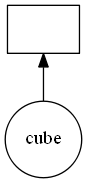

In [46]:
task.visualize()

The fun begins when you start adding more tasks.

A "delayed" object can be used as input for another function (or operator). This means that its result will then be used in the subsequent steps. The following example shows a linear DAG:

[[262144. 262144. 262144.]
 [262144. 262144. 262144.]
 [262144. 262144. 262144.]]


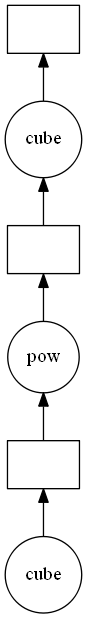

In [52]:
eighteenth_power = cube(square(task))  # [2 ** 3] ** 2 ** 3
print(eighteenth_power.compute())
eighteenth_power.visualize()

Say that we want to compute a complicated polynomial on two arrays.

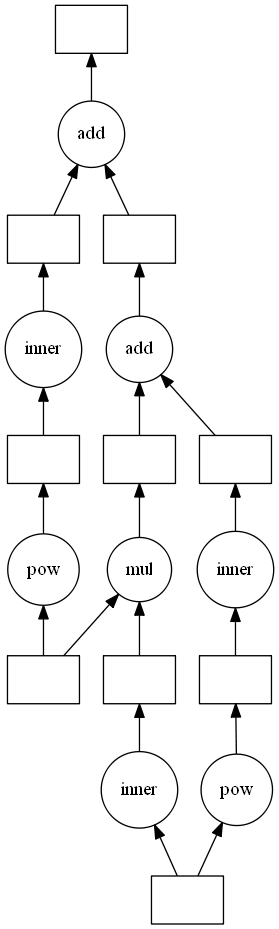

In [57]:
x = delayed(np.random.normal(100000))
y = delayed(np.random.normal(100000, 1, 1))

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2
polynomial.visualize()

Here, you see that the DAG got a bit more complex and that some of its branches are independent of others, and thus can be run in parallel.

In [120]:
A_LOT = 10_000_000

In [121]:
%%timeit

# Normal variant
x = np.random.normal(size=A_LOT)
y = np.random.normal(scale=.5, size=A_LOT)

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2

782 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
%%timeit

# Dask variant
x = delayed(np.random.normal(size=A_LOT))
y = delayed(np.random.normal(scale=.5, size=A_LOT))

polynomial = 4 * x ** 2 + 24 * x * y + 7 * y ** 2
polynomial.compute()

729 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Not a big gain, right?

Let's make a more complex example (summing the same polynomial for multiple arrays):

In [112]:
def polynomial_f(x, y):
    return 4 * x ** 2 + 24 * x * y + 7 * y ** 2

In [102]:
%%timeit

# Normal variant
total = np.zeros(A_LOT / 10)

for i in range(10):
    x = np.random.normal(size=A_LOT)
    y = np.random.normal(scale=.5, size=A_LOT)
    total += polynomial_f(x, y)
    
total.sum()

7.79 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


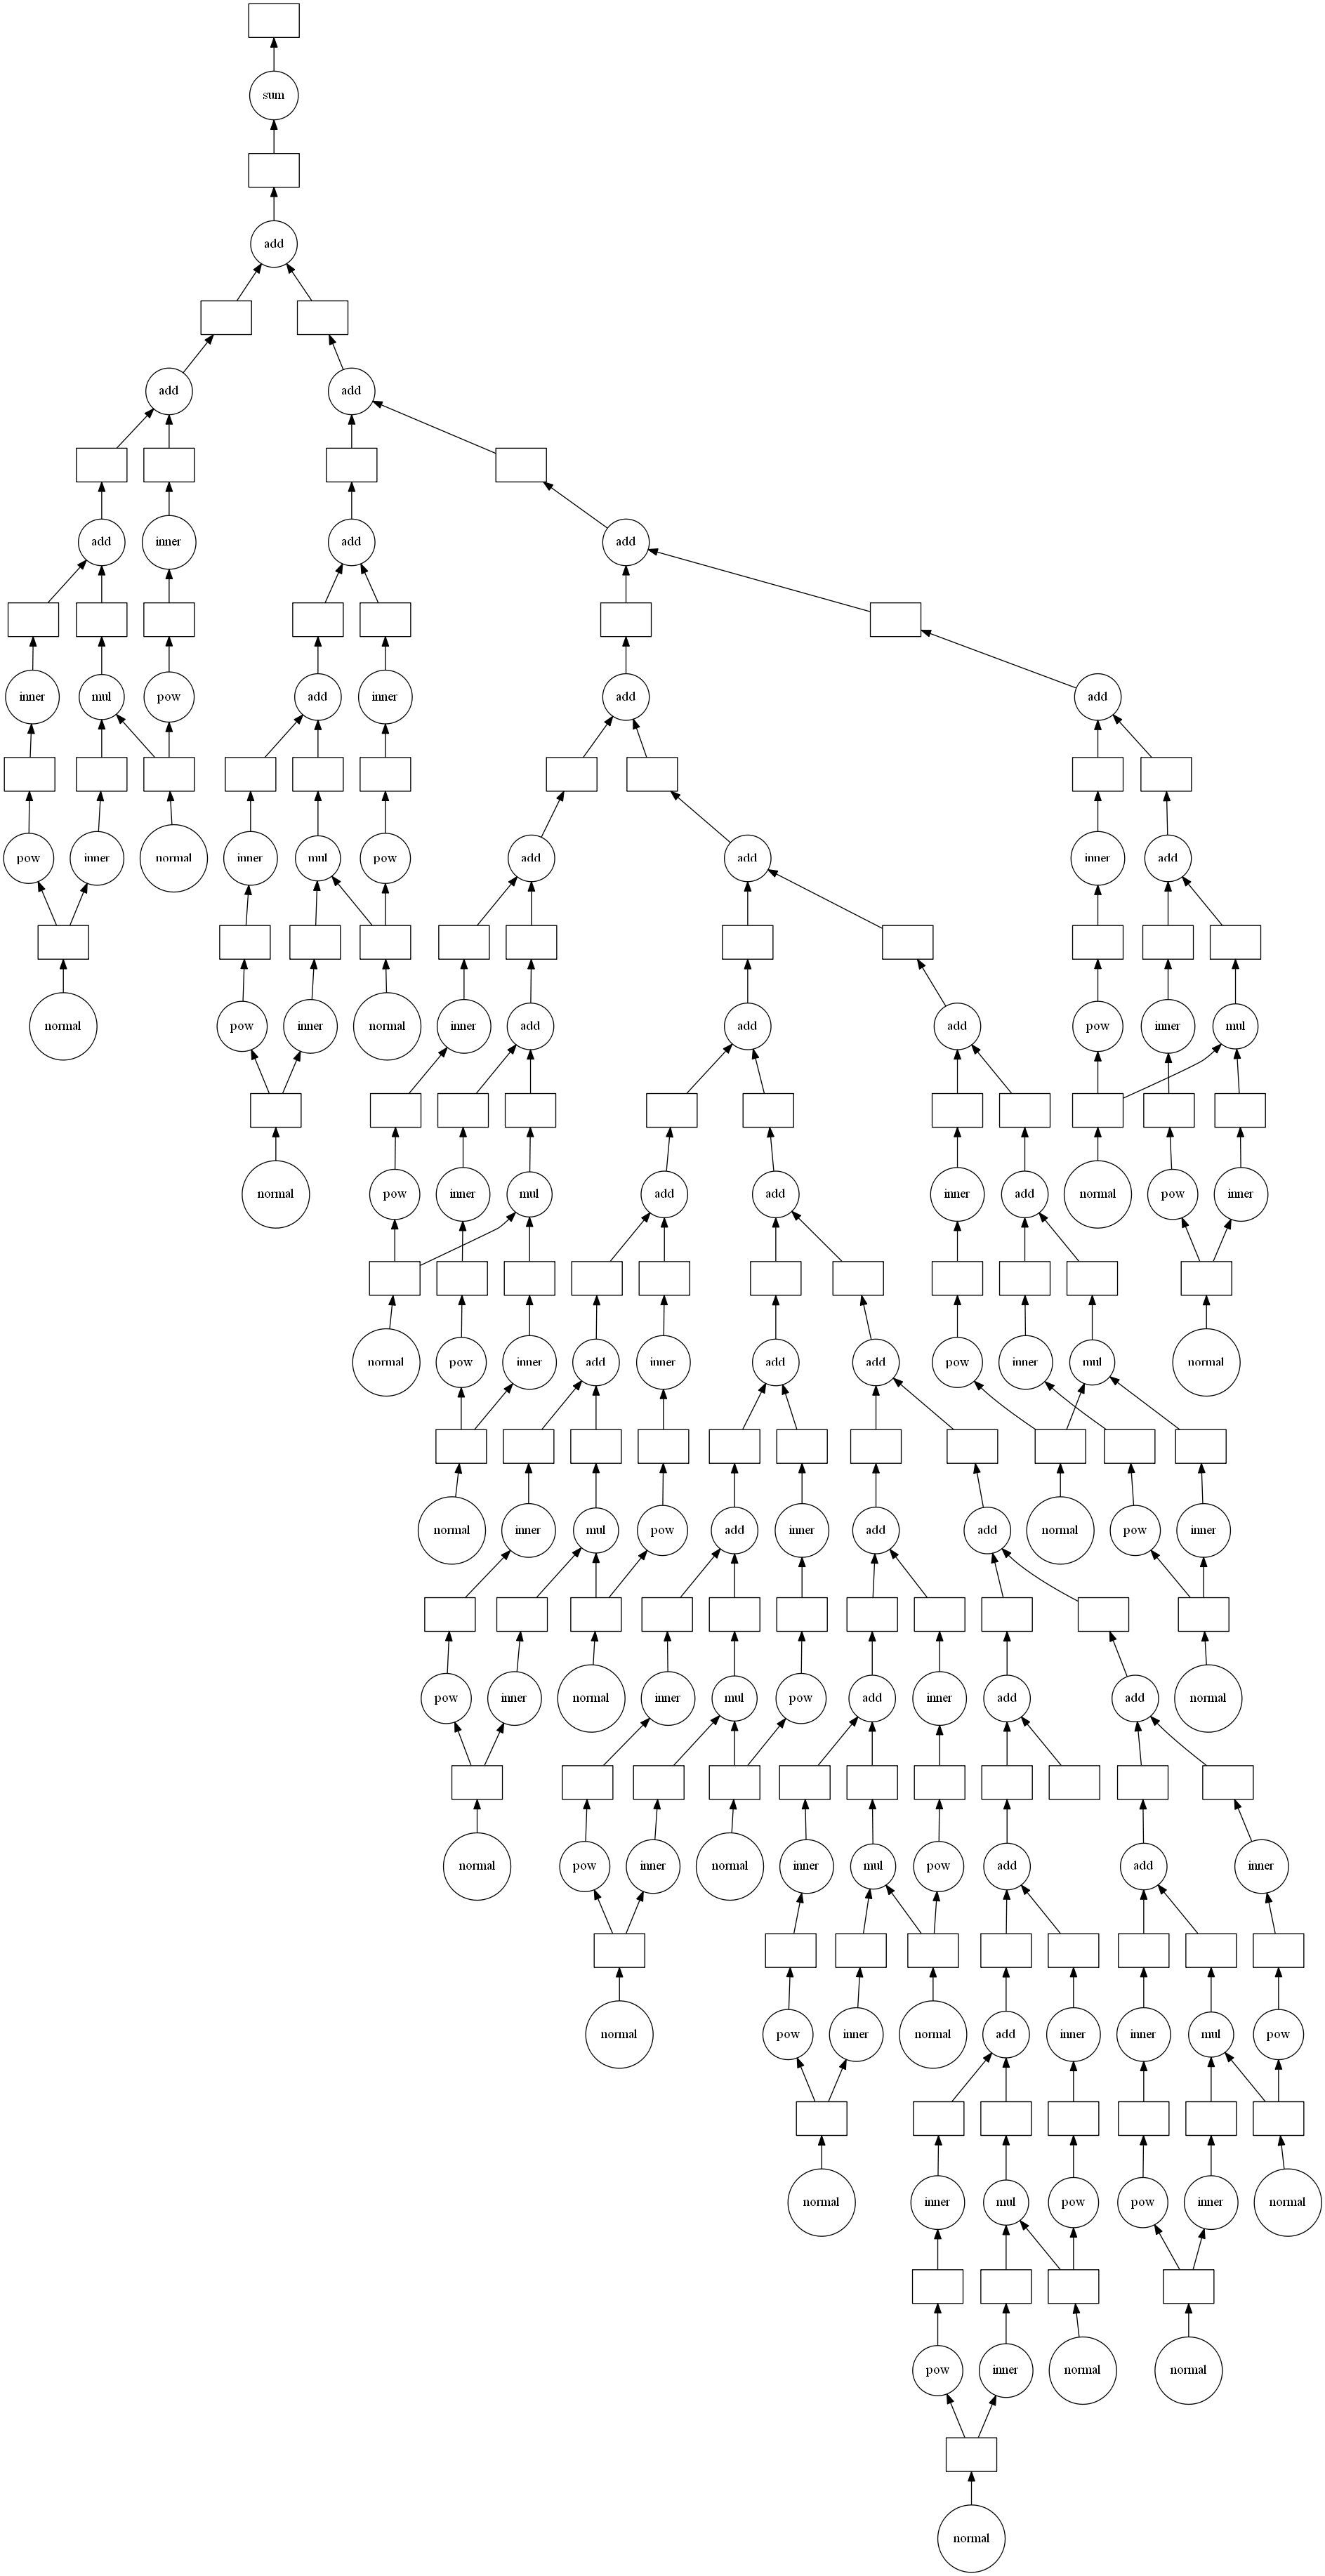

In [114]:
# Dask variant
total = delayed(np.zeros(A_LOT))

for i in range(10):
    x = delayed(np.random.normal)(size=A_LOT)
    y = delayed(np.random.normal)(scale=.5, size=A_LOT)
    total += polynomial_f(x, y)

total.sum().visualize()

Wow! How fast will it execute?

In [115]:
%%timeit
total.sum().compute()

6.17 s ± 270 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Scheduling

Any of the DAGs can be executed (when `compute()` is called) using a number of [schedulers](https://docs.dask.org/en/latest/scheduling.html). Based on the problem at hand, any of these might be the best for you (assuming that you have a multi-core processor):

- **synchronous** - Runs all tasks one after another with no parallelism. It might be effective when the tasks themselves are implemented as multithreaded by nature (e.g. in C library, releasing the GIL) or when there are no parallel branches.

- **threads** - Uses a thread pool (specifically, `multiprocessing.pool.ThreadPool` from the standard library) to assign tasks to multiple threads. It might be effective if the tasks spends most of the time outside Python and releases the GIL (numpy, pandas, ...) and when you have a lot of shared (read-only) memory.

- **processes** - This uses a pool of separate processes with no GIL and memory sharing - which makes it ideal for Python-dominant code with small input (as everything is copied, memory speed could be a bottleneck)

Standing a bit aside, the `dask.distributed` scheduler offers a slightly different API (see below).

Let's experiment with our DAG:

In [125]:
total = delayed(np.zeros(A_LOT))

for i in range(10):
    x = delayed(np.random.normal)(size=A_LOT)
    y = delayed(np.random.normal)(scale=.5, size=A_LOT)
    total += polynomial_f(x, y)

dag = total.sum()

In [129]:
%%timeit -n1 -r1

dag.compute(scheduler="synchronous")

8.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [130]:
%%timeit -n1 -r1

dag.compute(scheduler="threads")

6.05 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [131]:
%%timeit -n1 -r1

dag.compute(scheduler="processes")

35.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


The timing for processes is horrible! 

Let's build an counter example that will copy virtually zero memory and will spend all time in Python code:

4950


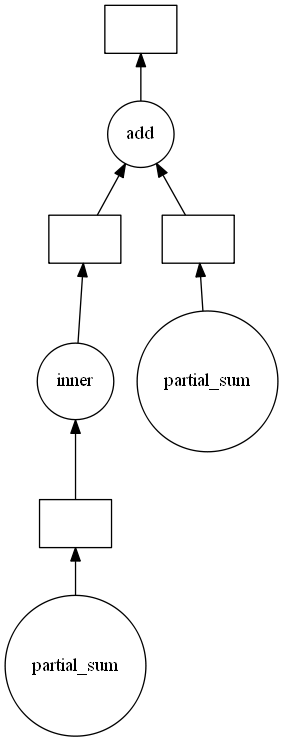

In [201]:
# Compute a sum of numbers from 0 to N (exclusive)
# Let's forget that it actually is 1/2(N^2 - N)

def partial_sum(lower, upper):
    return sum(range(lower, upper))

def total_sum(upper, chunk_size):
    lower = 0
    partial_sums = []
    while lower < upper:
        current_upper = min(lower + chunk_size, upper + 1)
        partial_sums.append(delayed(partial_sum)(lower, current_upper))
        lower += chunk_size
    return sum(partial_sums)

print(total_sum(100, 50).compute())
total_sum(100, 50).visualize()

In [202]:
%%timeit -n1 -r1

total_sum(100_000_000, 25_000_000).compute(scheduler="synchronous")

4.49 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [148]:
%%timeit -n1 -r1

total_sum(100_000_000, 25_000_000).compute(scheduler="threads")

3.58 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [149]:
%%timeit -n1 -r1

total_sum(100_000_000, 25_000_000).compute(scheduler="processes")

1.91 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


As expected, multiprocessing will help here (but only when the price of the task is high and the number of chunks small).

## Futures and distributed scheduling

Dask supports a real-time task framework that extends Python’s `concurrent.futures` interface. This interface is good for arbitrary task scheduling like dask.delayed, but is immediate rather than lazy, which provides some more flexibility in situations where the computations may evolve over time. It is described in the [official documentation](https://docs.dask.org/en/latest/futures.html)

For the futures to start, you need to have a connection to the distributed scheduler (locally or remotely).

- If you instantiate `dask.distributed.Client` without a scheduler (our case), this is implicitly created for you, together with a reasonable number of workers.
- If you want to start a scheduler yourself and manage the workers (perhaps running on different computers), you may go to the [documentation](https://distributed.dask.org/en/latest/quickstart.html).

In [171]:
from dask.distributed import Client

client = Client()

C:\Users\janpi\Miniconda3\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 59989 instead
  warnings.warn(


This scheduler works roughly like the executors from `concurrent.futures` and similarly, you execute the tasks (immediately and asynchronously) using its `submit` method. It can be set to use either processes (no argument needed) or threads (initalize with `processes=False`). 

In [183]:
def double(x):
    return x * 2

f = client.submit(double, 17)
f

<Future: pending, key: double-1705c0d15906114a168a0972cd7b85c5>

Instead of a direct result or a delayed object, we got a future and we can use it as we are used (or "would be used") to.

In [186]:
f.done()

True

In [187]:
f.result()

34

A single-task DAG is not very interesting, so let's find x^3 + x^2 (with an added time penalty).

One nice feature of the scheduler is that it offers a nice web-based monitoring tool, that typically starts on port 8787 (but it will issue warning if otherwise). There you can observe the execution progress, resources used and the DAG visualization. While the result of the future is computed, we can observer 

In [197]:
import time

def cube(x):
    time.sleep(20)
    return x ** 3

def square(x):
    time.sleep(10)
    return x ** 2

def add(x, y):
    return x + y


data = np.array([1, 2, 3])

squared = client.submit(square, data)
cubed = client.submit(cube, data)
poly = client.submit(add, squared, cubed)

poly


<Future: pending, key: add-72c660e35e7ce9a4b989666eaf708012>

In [198]:
poly.result()

array([ 2, 12, 36])

**Exercise:** Rewrite the `total_sum` function from above so that instead of creating `delayed`s, it submits the partial tasks to a client and returns a future. Use this to compute the sum of numbers from 1 to 1 000 000 000, using an appropriate chunk size. Prepare a coffee, relax and observe the dashboard.

In [180]:
def total_sum(upper, chunk_size):
    lower = 0
    partial_results = []
    while lower < upper:
        current_upper = min(lower + chunk_size, upper + 1)
        partial_result = ...
        partial_results.append(partial_result)
        lower += chunk_size
    return ...

f = ...

In [181]:
f.result()

AttributeError: 'ellipsis' object has no attribute 'result'

## Parallel data structures

One of the main aims of the dask library is to enable and parallelize working with numpy arrays and pandas dataframes 
that do not fit in the memory. This is done by:cutting the data structures into smaller parts and creating a DAG that computes the partial results and aggregates them together. You will use the respective API in the same way as the mimicked one with two modifications:

- you need to specify (or at least be aware) how the structures are chunked.
- you use the `compute()` method as all operations are delayed by default.


### [Dask Array](https://docs.dask.org/en/latest/array.html)

Note: Dask can use any sufficiently NumPy-like arrays such as CuPy or Spare arrays.

![Dask Array](images/dask-array.svg)

In [216]:
import dask.array as da

x = da.random.random((6000, 6000), chunks=(2000, 2000))
x

dask.array<random_sample, shape=(6000, 6000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

Any operation (including indexing), is delayed:

In [217]:
x[0,0]

dask.array<getitem, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [237]:
x[0,0].compute()  # By default, use threading

0.981053074015103

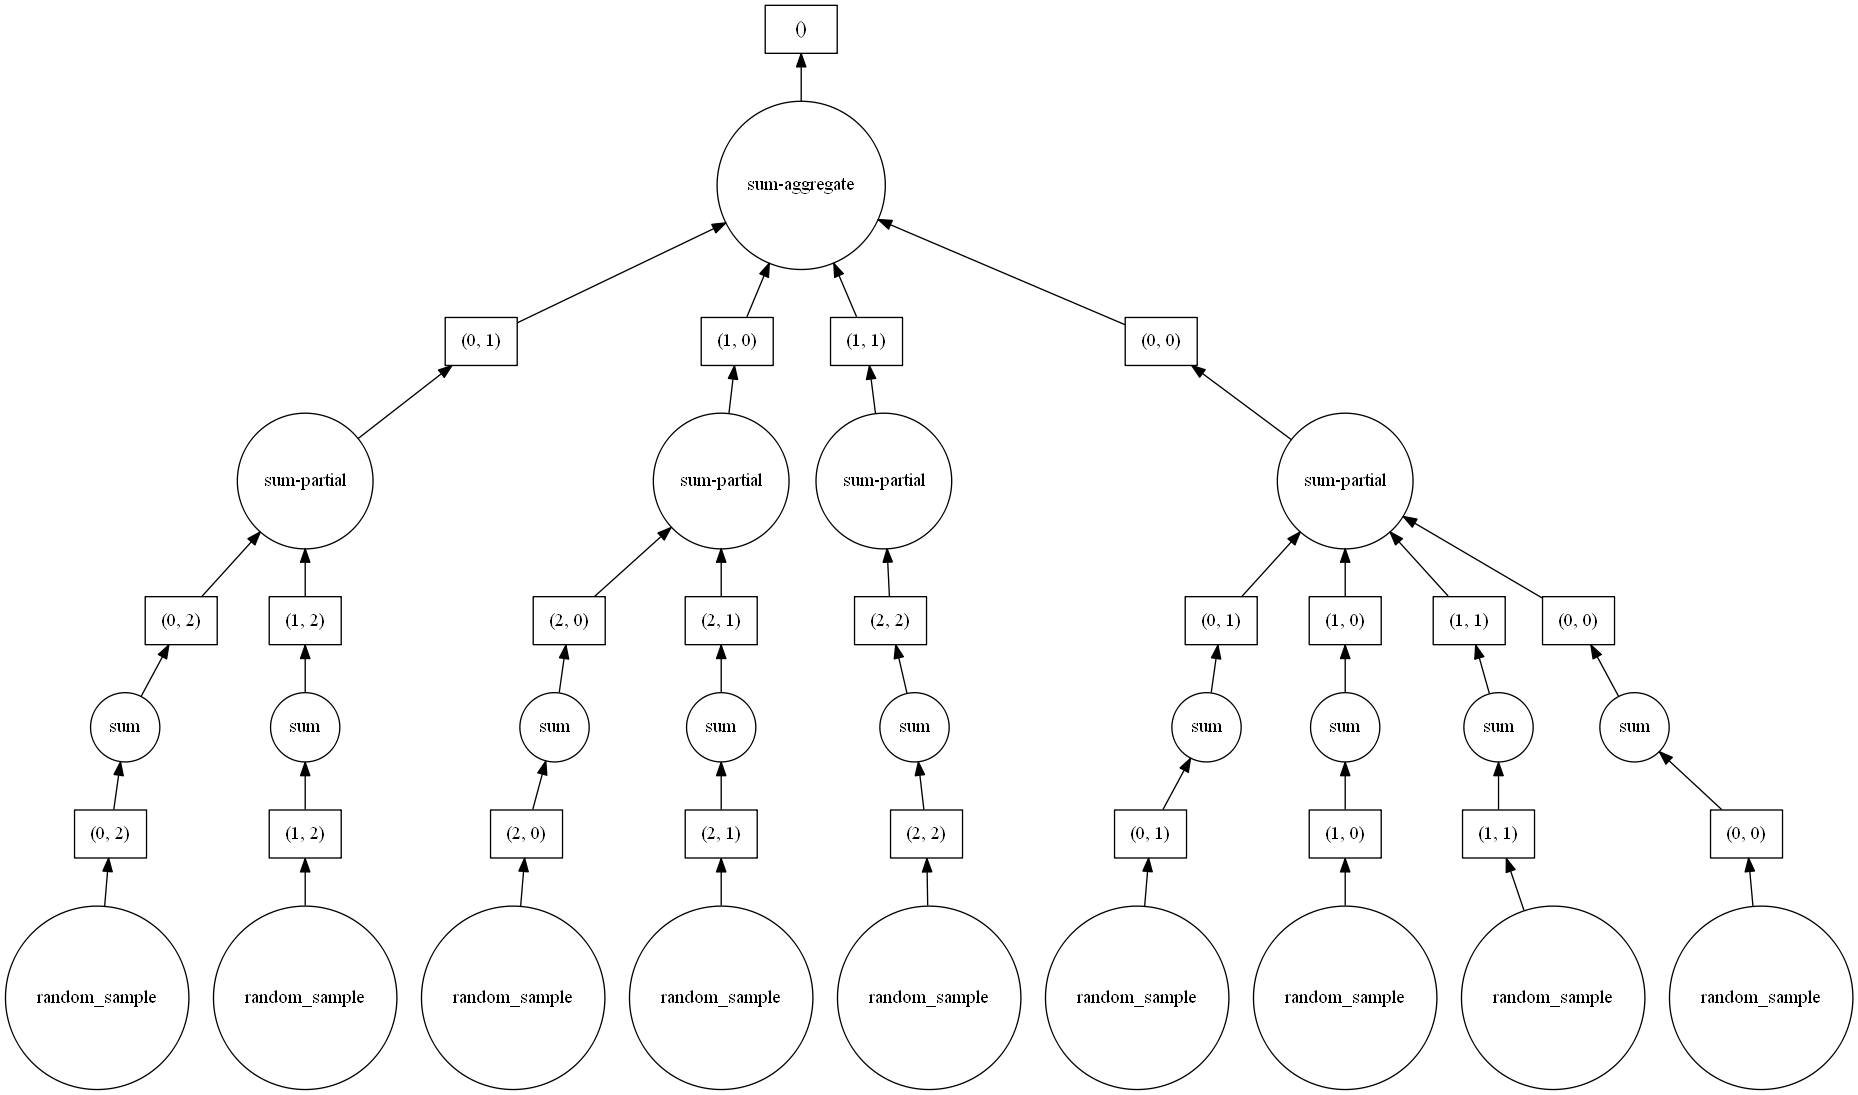

In [219]:
x.sum().visualize()

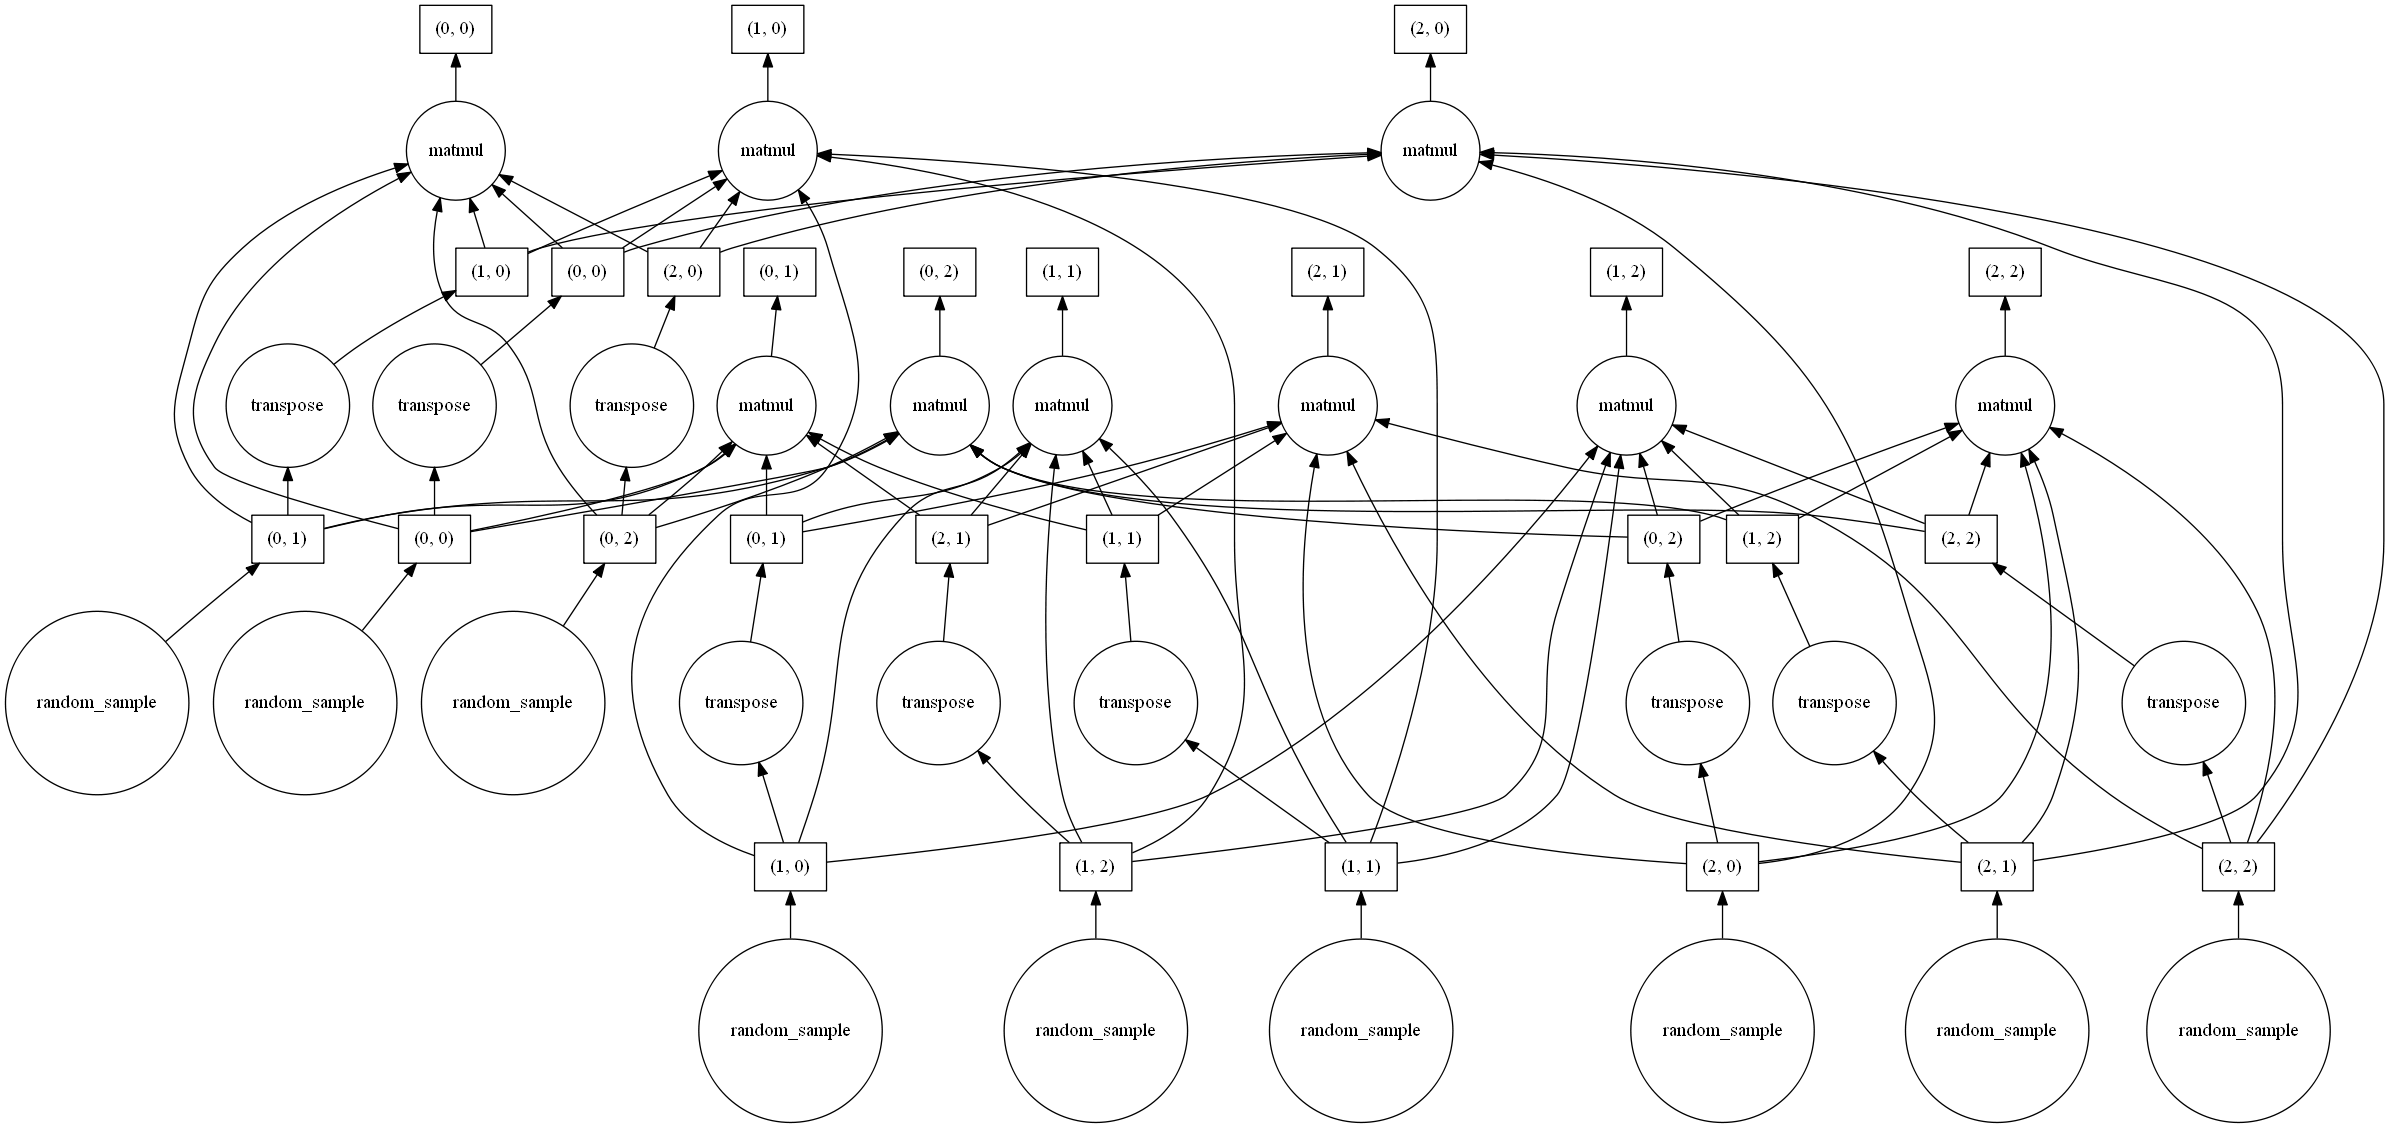

In [220]:
(x @ x.T).visualize()

In [225]:
(x @ x.T).compute()

array([[1990.98645826, 1501.05221318, 1498.18976597, ..., 1517.05694038,
        1472.92410007, 1490.2268234 ],
       [1501.05221318, 2006.6433341 , 1510.41442997, ..., 1511.21393287,
        1492.52589543, 1480.14980145],
       [1498.18976597, 1510.41442997, 2014.71975411, ..., 1513.40985813,
        1501.2163518 , 1500.58323029],
       ...,
       [1517.05694038, 1511.21393287, 1513.40985813, ..., 2031.03456226,
        1484.07146269, 1505.49083034],
       [1472.92410007, 1492.52589543, 1501.2163518 , ..., 1484.07146269,
        1972.13497035, 1466.5029724 ],
       [1490.2268234 , 1480.14980145, 1500.58323029, ..., 1505.49083034,
        1466.5029724 , 1977.12098318]])

You can use submit the computation to obtain a future as well.

In [230]:
f = client.submit(da.exp, x)
f

In [233]:
f.result()

dask.array<exp, shape=(6000, 6000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

**Exercise:** Compute the sum of numbers from 0 to 1 000 000 000 using the dask array API.

Hint: You can use the `da.arange` function.

In [ ]:
%%timeit
array = ...
result = ...

### [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html)

A Dask DataFrame is a large parallel DataFrame composed of many smaller Pandas DataFrames, split along the index. These Pandas DataFrames may live on disk for larger-than-memory computing on a single machine, or on many different machines in a cluster. One Dask DataFrame operation triggers many operations on the constituent Pandas DataFrames. (from the docs)



Let's use the example from pandas lesson and reuse it line by line.

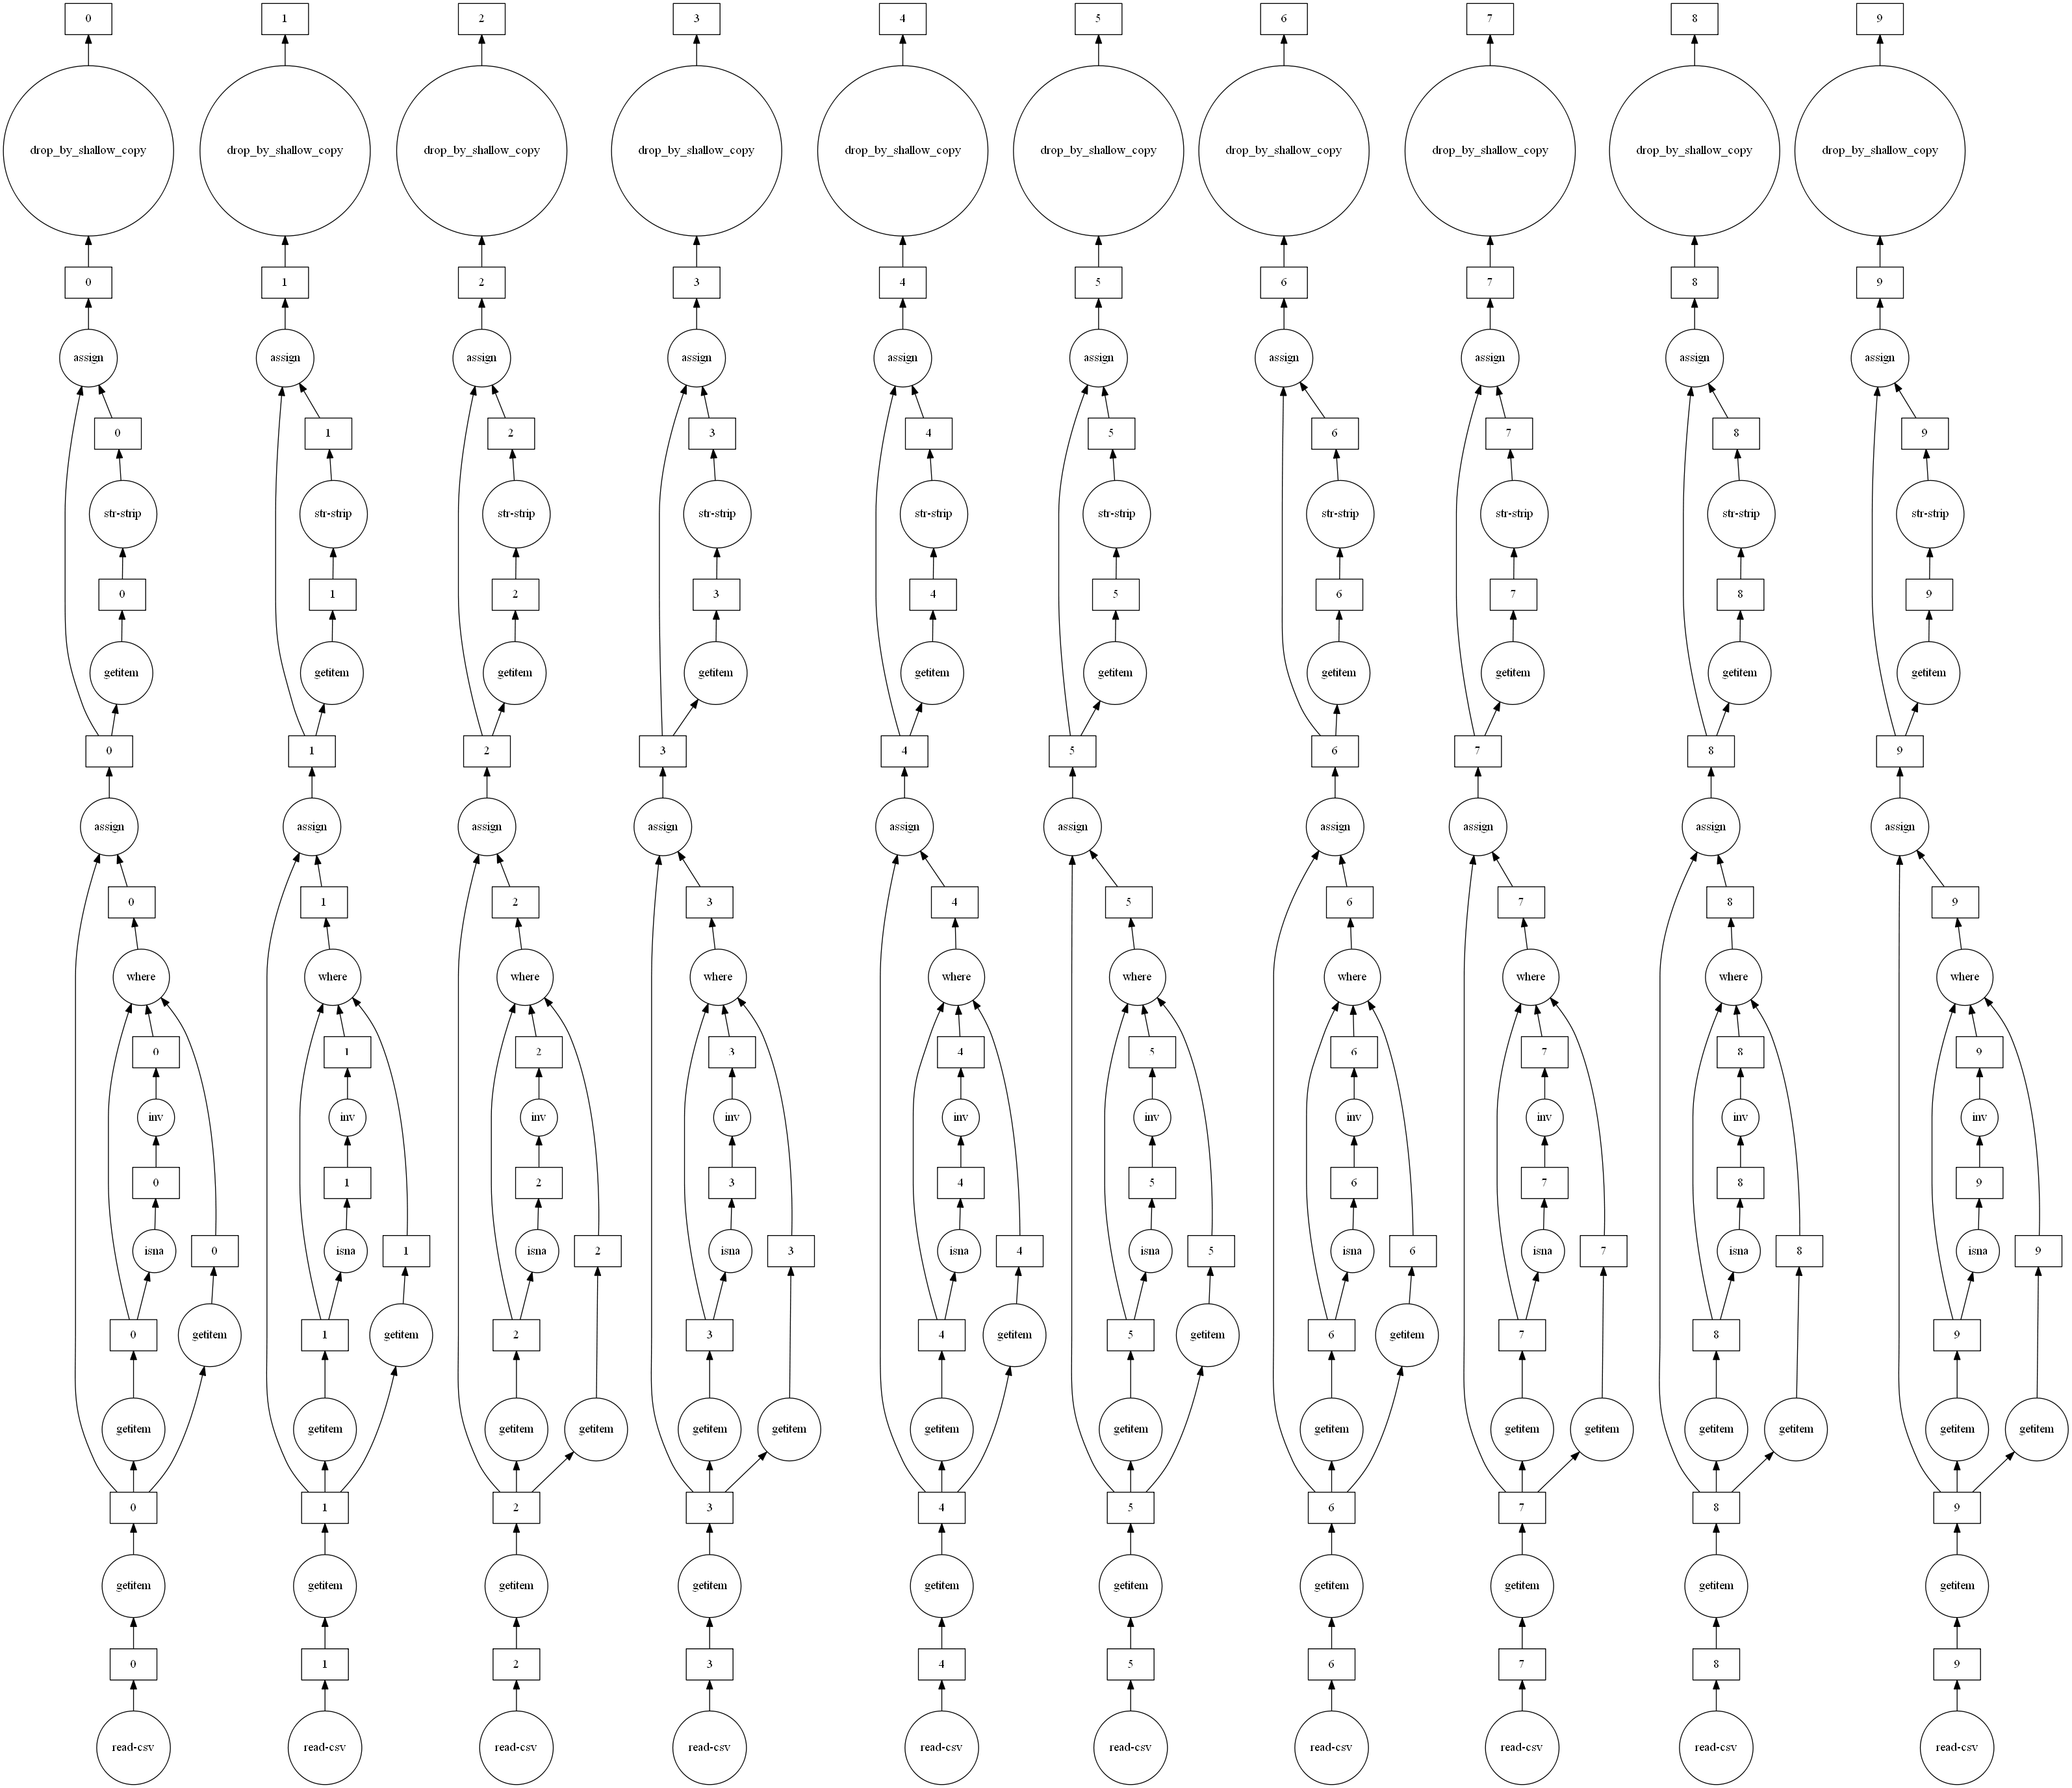

In [254]:
import dask.dataframe as dd

# Read data
df_raw = dd.read_csv("data/laser_incidents_2015-2020_raw.csv", blocksize=500000, dtype=object)

# Remove unnecessary columns
df = df_raw[
    [column for column in df_raw.columns if "Unnamed" not in column]
]

# There are "State" and "State " column
df = df.assign(
    State=df["State"].where(
        ~df["State"].isna(), df["State "]
    )    
)

# Strip white space from state names
df = df.assign(State=df["State"].str.strip())

# Drop columns we do not need any more
df = df.drop(columns=["State ", "Aviation Altitude"])

df.visualize()

In [270]:
altitude = dd.to_numeric(
    df.Altitude,
    errors="coerce")

mean_hawaii_altitude = altitude[df.State == "Hawaii"].mean()

In [271]:
mean_hawaii_altitude.compute()

4564.536585365854

### [Dask Bag](https://docs.dask.org/en/latest/bag.html)

Dask Bag implements operations like map, filter, fold, and groupby on collections of generic Python objects (usually not array and data frames).

The following example is taken (and shortened) from the [official documentation](https://examples.dask.org/bag.html).

In [277]:
import dask
import json

b = dask.datasets.make_people()                 # Make records of people
b.map(json.dumps).to_textfiles('data/dask-example-*.json')   # Encode as JSON, write to disk

['C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-0.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-1.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-2.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-3.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-4.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-5.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-6.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-7.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-8.json',
 'C:/Users/janpi/Documents/code/collaboration/hilase-python-course-2021/data/dask-example-9.json']

In [278]:
!head -n 2 data/0.json

{"age": 27, "name": ["Janita", "Aguilar"], "occupation": "Stone Sawyer", "telephone": "(856) 270-7246", "address": {"address": "380 Fredson Green", "city": "Alabaster"}, "credit-card": {"number": "2322 0721 5889 3558", "expiration-date": "02/18"}}
{"age": 33, "name": ["Kathrin", "Moses"], "occupation": "Pig Man", "telephone": "990.308.2145", "address": {"address": "957 Dalewood Concession road", "city": "Jackson"}, "credit-card": {"number": "5183 9442 8454 7624", "expiration-date": "01/18"}}


In [279]:
import dask.bag as db
import json

b = db.read_text('data/*.json').map(json.loads)
b

dask.bag<loads, npartitions=20>

In [280]:
b.take(2)

({'age': 27,
  'name': ['Janita', 'Aguilar'],
  'occupation': 'Stone Sawyer',
  'telephone': '(856) 270-7246',
  'address': {'address': '380 Fredson Green', 'city': 'Alabaster'},
  'credit-card': {'number': '2322 0721 5889 3558',
   'expiration-date': '02/18'}},
 {'age': 33,
  'name': ['Kathrin', 'Moses'],
  'occupation': 'Pig Man',
  'telephone': '990.308.2145',
  'address': {'address': '957 Dalewood Concession road', 'city': 'Jackson'},
  'credit-card': {'number': '5183 9442 8454 7624',
   'expiration-date': '01/18'}})

In [281]:
b.filter(lambda record: record['age'] > 30).take(2)  # Select only people over 30

({'age': 33,
  'name': ['Kathrin', 'Moses'],
  'occupation': 'Pig Man',
  'telephone': '990.308.2145',
  'address': {'address': '957 Dalewood Concession road', 'city': 'Jackson'},
  'credit-card': {'number': '5183 9442 8454 7624',
   'expiration-date': '01/18'}},
 {'age': 49,
  'name': ['Asa', 'Brennan'],
  'occupation': 'Knitter',
  'telephone': '(630) 431-0705',
  'address': {'address': '681 Capra Garden', 'city': 'Utica'},
  'credit-card': {'number': '3766 447809 36358', 'expiration-date': '04/19'}})

In [284]:
# 10 most frequent occupations of people above 30
result = (b.filter(lambda record: record['age'] > 30)
           .map(lambda record: record['occupation'])
           .frequencies(sort=True)
           .topk(10, key=1))
result

dask.bag<topk-aggregate, npartitions=1>

In [283]:
result.compute()

[('Recorder', 23),
 ('Post Sorter', 22),
 ('Sail Maker', 22),
 ('Teacher', 22),
 ('Actor', 22),
 ('Musician', 22),
 ('Shift Controller', 22),
 ('Investment Advisor', 22),
 ('Administrator', 21),
 ('Marine Surveyor', 21)]

In [285]:
df = result.to_dataframe()
df.head()

,0,1
0,Recorder,23
1,Post Sorter,22
2,Sail Maker,22
3,Teacher,22
4,Actor,22


## Alternatives

There are many alternatives that each target different aspects of the parallelization, e.g.:

- [ray](https://github.com/ray-project/ray) - an open source framework that provides a simple, universal API for building distributed applications. (cited)
- [pyspark](https://spark.apache.org/docs/latest/api/python/pyspark.html) - a Python client for the (huge) Spark ecosystem (not cited)
- [joblib](https://joblib.readthedocs.io/en/latest/) - a set of tools to provide lightweight pipelining in Python. In particular: a) transparent disk-caching of functions and lazy re-evaluation (memoize pattern), b) easy simple parallel computing. (cited)
- [celery](https://docs.celeryproject.org/en/stable/) - a simple, flexible, and reliable distributed system to process vast amounts of messages, while providing operations with the tools required to maintain such a system (cited)
- [luigi](https://github.com/spotify/luigi) - a Python module that helps you build complex pipelines of batch jobs. It handles dependency resolution, workflow management, visualization etc. (cited)
- [airflow](https://airflow.apache.org/) - a platform created by the community to programmatically author, schedule and monitor workflows. (cited)
- ...